# Assignment 3

Gender: Gender of the individual

Age: Age of the individual

Height: Height of the individual

Weight: Weight of the individual

family_history_with_overweight: Whether the individual has a family member suffered or suffers from overweight

FAVC: Frequency of consuming high-calorie foods

FCVC: Frequency of of consuming vegetables

NCP: Number of main meals per day

CAEC: Frequency of eating any food between meals

SMOKE: Whether the individual smoke

CH2O: Amount of water consumed daily

SCC: Whether the individual monitors their daily calories

FAF: Frequency of having physical activity

TUE: Time using technological devices (cell phone, videogames, television, computer and others)

CALC: Frequency of consuming alcohol

MTRANS: Mode of transportation used by the individual (e.g., walking, biking, public transportation, etc.).

NObeyesdad: Obesity level

**Class Labels**

Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, and Obesity Type III

**Research Questions**:

1. Can we predict an individual's obesity level based on their eating habits and physical condition?

1. What are the key factors that influence obesity levels in individuals? 

1. What is the effect of the most important predictors

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

seed = 42
np.random.seed(seed)

In [42]:
DATA_DIR = "ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(DATA_DIR)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Read Data to dataframe and convert to categorical 

In [43]:
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

scaler = MinMaxScaler()

df[numerical_features] = scaler.fit_transform(df[numerical_features])

object_columns = df.select_dtypes(include=['object']).columns
bool_columns = df.select_dtypes(include=['bool']).columns
df[object_columns] = df[object_columns].astype('category')
df[bool_columns] = df[bool_columns].astype('category')
mapping_dict = {}

for col in df.select_dtypes(['category']).columns:
    mapping_dict[col] = dict(enumerate(df[col].cat.categories))
inverse_mapping_dict = {col: {v: k for k, v in mapping_dict[col].items()} for col in mapping_dict}

# mapping_dict

df[object_columns] = df[object_columns].apply(lambda x: x.cat.codes)
df[bool_columns] = df[bool_columns].apply(lambda x: x.cat.codes)

print(df.head())

X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

X.to_csv('X.csv', index=False)

   Gender       Age    Height    Weight  family_history_with_overweight  FAVC  \
0       0  0.148936  0.320755  0.186567                               1     0   
1       0  0.148936  0.132075  0.126866                               1     0   
2       1  0.191489  0.660377  0.283582                               1     0   
3       1  0.276596  0.660377  0.358209                               0     0   
4       1  0.170213  0.622642  0.379104                               0     0   

   FCVC       NCP  CAEC  SMOKE  CH2O  SCC       FAF  TUE  CALC  MTRANS  \
0   0.5  0.666667     2      0   0.5    0  0.000000  0.5     3       3   
1   1.0  0.666667     2      1   1.0    1  1.000000  0.0     2       3   
2   0.5  0.666667     2      0   0.5    0  0.666667  0.5     1       3   
3   1.0  0.666667     2      0   0.5    0  0.666667  0.0     1       4   
4   0.5  0.000000     2      0   0.5    0  0.000000  0.0     2       3   

   NObeyesdad  
0           1  
1           1  
2           1  
3   

In [44]:
mapping_dict

{'Gender': {0: 'Female', 1: 'Male'},
 'family_history_with_overweight': {0: 'no', 1: 'yes'},
 'FAVC': {0: 'no', 1: 'yes'},
 'CAEC': {0: 'Always', 1: 'Frequently', 2: 'Sometimes', 3: 'no'},
 'SMOKE': {0: 'no', 1: 'yes'},
 'SCC': {0: 'no', 1: 'yes'},
 'CALC': {0: 'Always', 1: 'Frequently', 2: 'Sometimes', 3: 'no'},
 'MTRANS': {0: 'Automobile',
  1: 'Bike',
  2: 'Motorbike',
  3: 'Public_Transportation',
  4: 'Walking'},
 'NObeyesdad': {0: 'Insufficient_Weight',
  1: 'Normal_Weight',
  2: 'Obesity_Type_I',
  3: 'Obesity_Type_II',
  4: 'Obesity_Type_III',
  5: 'Overweight_Level_I',
  6: 'Overweight_Level_II'}}

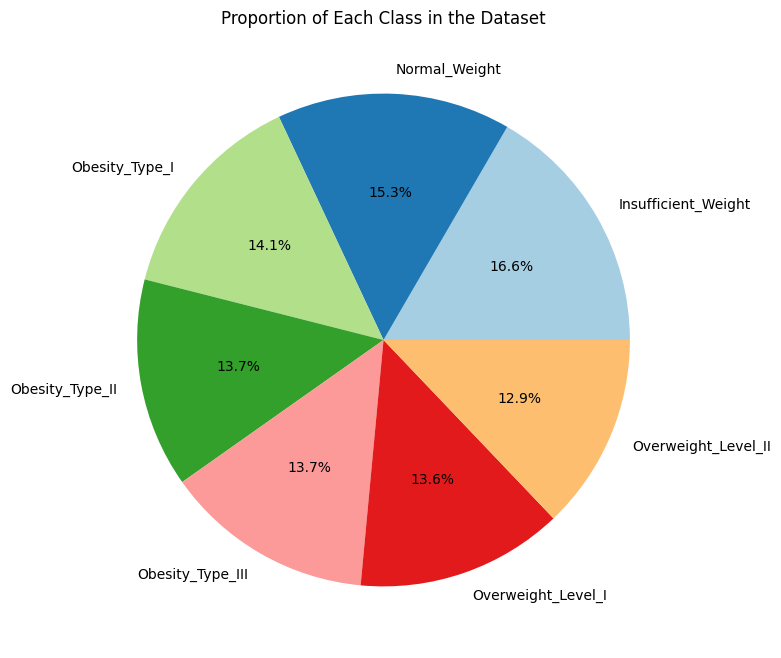

In [45]:
class_proportion = df['NObeyesdad'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 8))
class_proportion.plot(kind='pie', autopct='%1.1f%%', 
                      colors=plt.cm.Paired.colors, labels = mapping_dict['NObeyesdad'].values())
plt.title('Proportion of Each Class in the Dataset')
plt.ylabel('')
plt.show()

#### Method 1: Logistic Regression

The coefficients of the logistic regression model indicate the importance and influence of each feature on the obesity levels.

This helps identify which factors are significant predictors of obesity.

In [46]:
pipeline = Pipeline([
    ('logistic', LogisticRegression(max_iter=1000, random_state=seed))
])

param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'logistic__penalty': ['l2'], 
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy',  n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best Parameters:", grid_result.best_params_)
print("Best Score:", grid_result.best_score_)

best_params = grid_result.best_params_

best_log_reg = LogisticRegression(max_iter=1000, random_state=seed, C=best_params['logistic__C'], penalty=best_params['logistic__penalty'])

best_log_reg.fit(X_train, y_train)

y_pred_log = best_log_reg.predict(X_test)

print("\nLogistic Regression\n")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Coefficients:\n", pd.DataFrame(best_log_reg.coef_.T, X.columns, columns=best_log_reg.classes_))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'logistic__C': 100, 'logistic__penalty': 'l2'}
Best Score: 0.8990998625744389

Logistic Regression

Accuracy: 0.9069400630914827
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92        86
           1       0.93      0.74      0.83        93
           2       0.98      0.92      0.95       102
           3       0.93      1.00      0.96        88
           4       1.00      0.99      0.99        98
           5       0.82      0.83      0.82        88
           6       0.82      0.87      0.85        79

    accuracy                           0.91       634
   macro avg       0.91      0.91      0.90       634
weighted avg       0.91      0.91      0.91       634

Confusion Matrix:
 [[85  1  0  0  0  0  0]
 [14 69  0  0  0  8  2]
 [ 0  0 94  6  0  0  2]
 [ 0  0  0 88  0  0  0]
 [ 0  0  0  1 97  0  0]
 [ 0  4  0  0  0 73 11]
 [ 0  0  

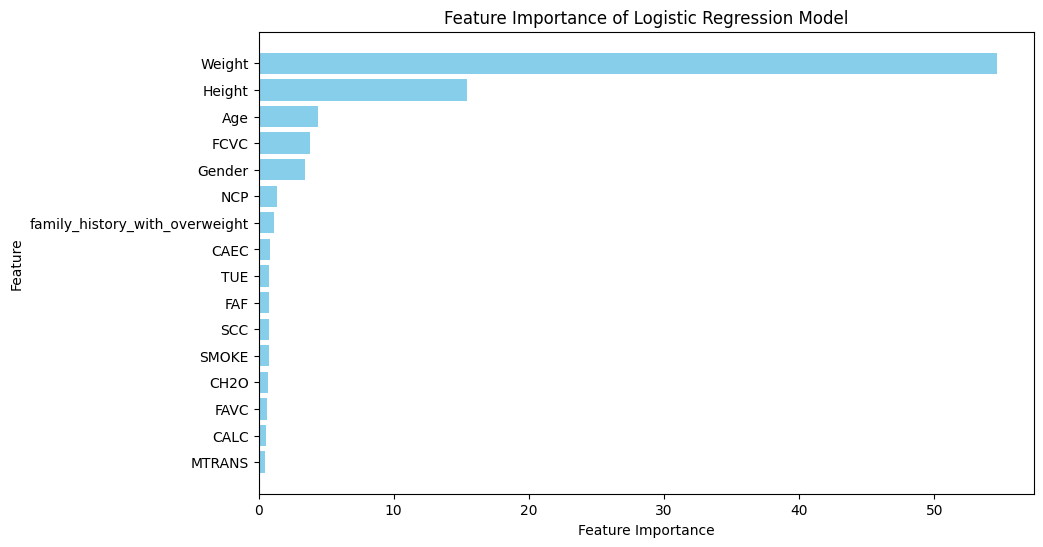

In [47]:
total_coefficients = np.sum(np.abs(best_log_reg.coef_), axis=0)/y.nunique()
sorted_indices = np.argsort(total_coefficients)
sorted_coefficients = total_coefficients[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Logistic Regression Model')
plt.show()

#### Method 2: Random Forest Classifier

The feature importance scores from the random forest model highlight the key factors influencing obesity levels.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest Classifier

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9560009161704077
Accuracy:
 0.9479495268138801

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97        86
           1       0.82      0.96      0.89        93
           2       0.98      0.96      0.97       102
           3       0.97      0.99      0.98        88
           4       1.00      0.99      0.99        98
           5       0.93      0.85      0.89        88
           6       0.97      0.92      0.95        79

    accuracy                           0.95       634
   macro avg       0.95      0.95      0.95       634
weighted avg       0.95      0.95      0.95       634


Confusion Matrix:
 [[82  4  0  0  0  0  0]
 [ 1 89  0  0  0  3  0]
 [ 0  1 98  3  0  0  0]
 [ 0  0  1 87  0  0  0]
 [ 0  0

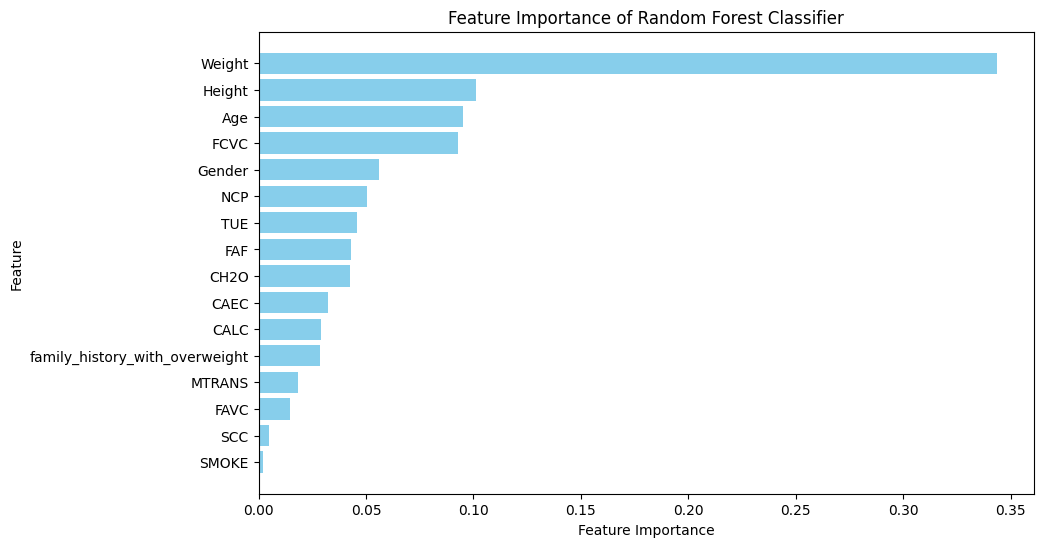

In [48]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

rf_clf = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Random Forest Classifier\n")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

y_pred_rf = grid_search.predict(X_test)

print("Accuracy:\n",accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_rf))

best_rf_clf = grid_search.best_estimator_
feature_importance = pd.DataFrame(best_rf_clf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feature_importance_asc = feature_importance.sort_values('Importance', ascending=True)
print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_asc.index, feature_importance_asc['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

#### Method 3: Support Vector Machine

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9498946404031148

SVM Classifier

Accuracy: 0.9637223974763407

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96        86
           1       0.99      0.89      0.94        93
           2       0.99      0.96      0.98       102
           3       0.96      1.00      0.98        88
           4       1.00      0.99      0.99        98
           5       0.94      0.95      0.95        88
           6       0.95      0.95      0.95        79

    accuracy                           0.96       634
   macro avg       0.96      0.96      0.96       634
weighted avg       0.96      0.96      0.96       634


Confusion Matrix:
 [[86  0  0  0  0  0  0]
 [ 8 83  0  0  0  2  0]
 [ 0  0 98  3  0  0  1]
 [ 0  0  0 88  0  0  0]
 [ 0  0  0  1 97  0  0]
 [ 0  1  0  0  0 84  3]
 [ 0  0  

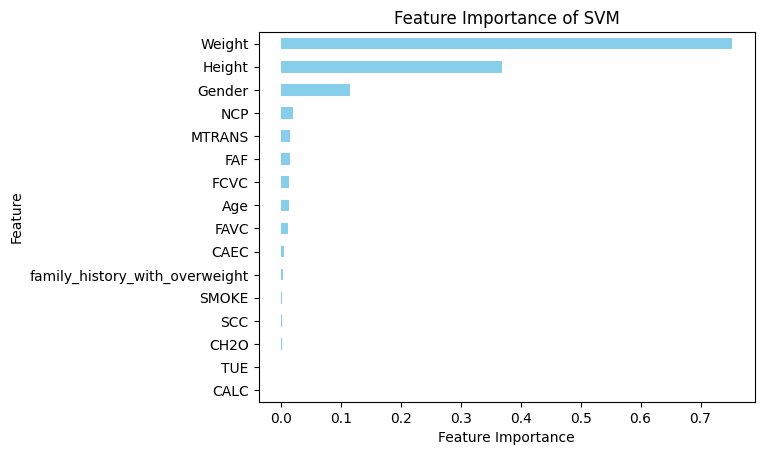

In [54]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

svm_clf = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_svm_clf = grid_search.best_estimator_
y_pred_svm = best_svm_clf.predict(X_test)

print("\nSVM Classifier\n")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

result_svr = permutation_importance(best_svm_clf, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1)
sorted_idx = result_svr.importances_mean
feat_names = list(X.columns)

importance = pd.DataFrame(sorted_idx, index=feat_names, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', title='Feature Importance of SVM', color='skyblue', legend=False)
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()

#### Method 4: Neural Network

In [57]:
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='tanh', learning_rate='adaptive', learning_rate_init=0.001, max_iter=500, random_state=seed)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

Accuracy: 0.9716088328075709
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        86
           1       0.98      0.91      0.94        93
           2       0.99      0.97      0.98       102
           3       0.97      0.99      0.98        88
           4       1.00      0.99      0.99        98
           5       0.94      0.97      0.96        88
           6       0.97      0.97      0.97        79

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



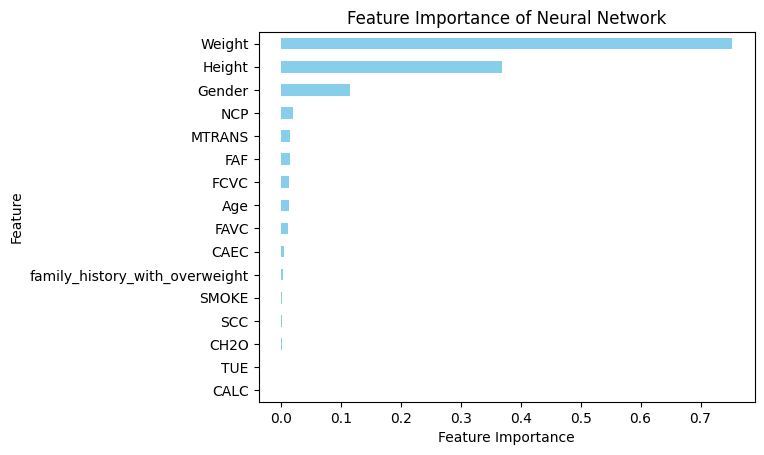

In [58]:
result_nn = permutation_importance(nn_model, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1)
sorted_idx = result_svr.importances_mean
feat_names = list(X.columns)

importance = pd.DataFrame(sorted_idx, index=feat_names, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', title='Feature Importance of Neural Network', color='skyblue', legend=False)
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()

In [59]:
class_name = mapping_dict['NObeyesdad']
class_name

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Obesity_Type_I',
 3: 'Obesity_Type_II',
 4: 'Obesity_Type_III',
 5: 'Overweight_Level_I',
 6: 'Overweight_Level_II'}

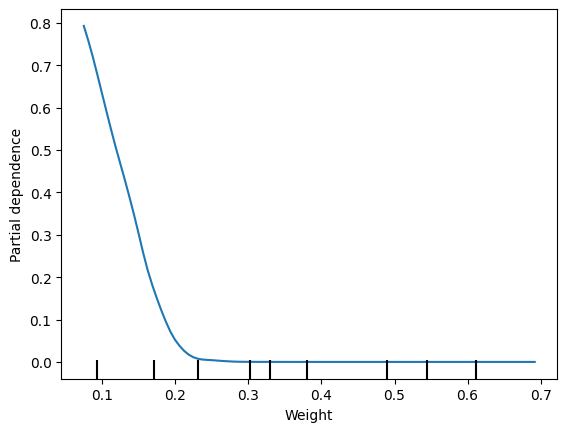

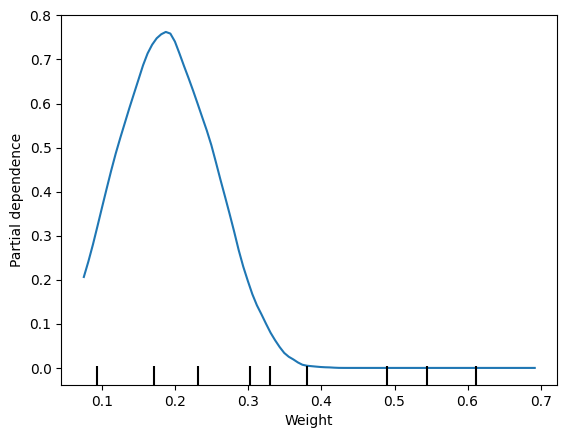

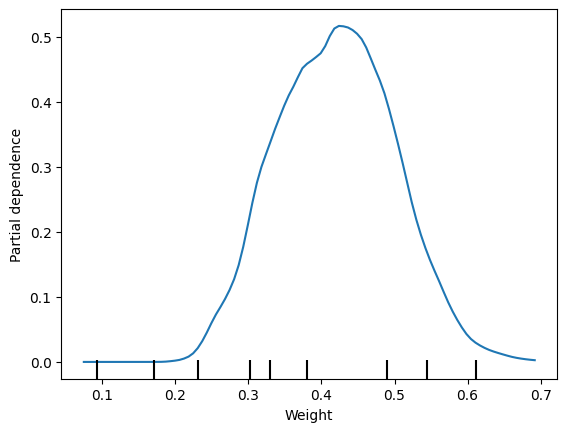

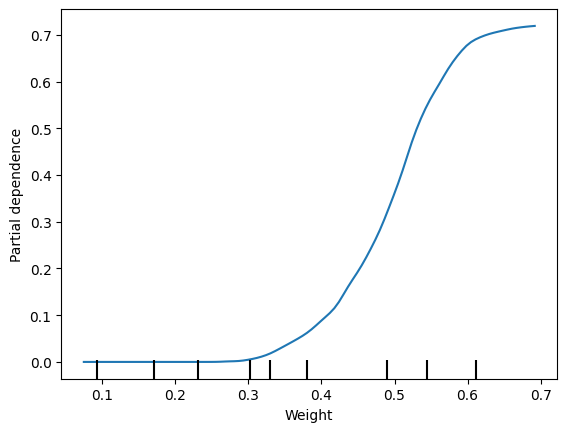

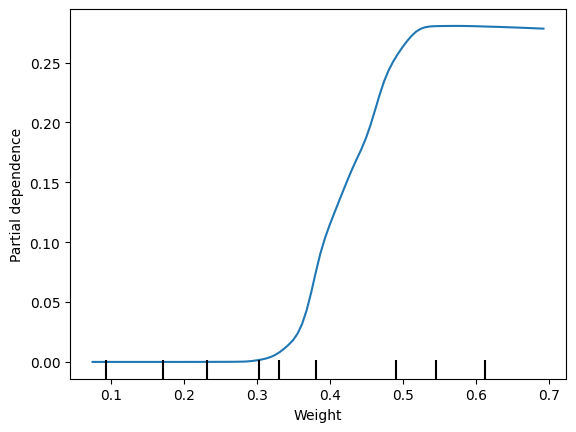

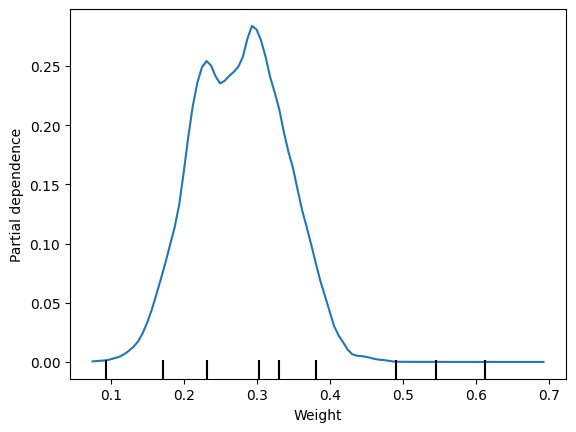

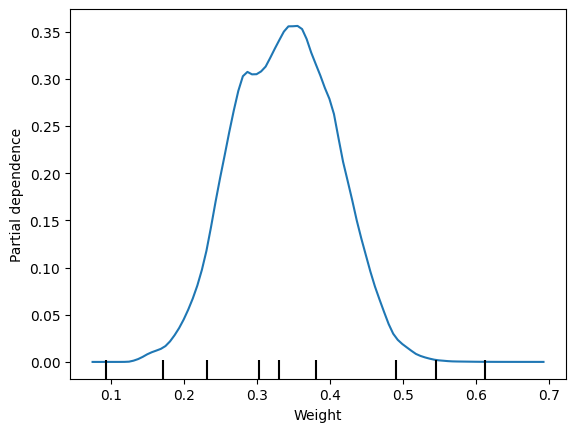

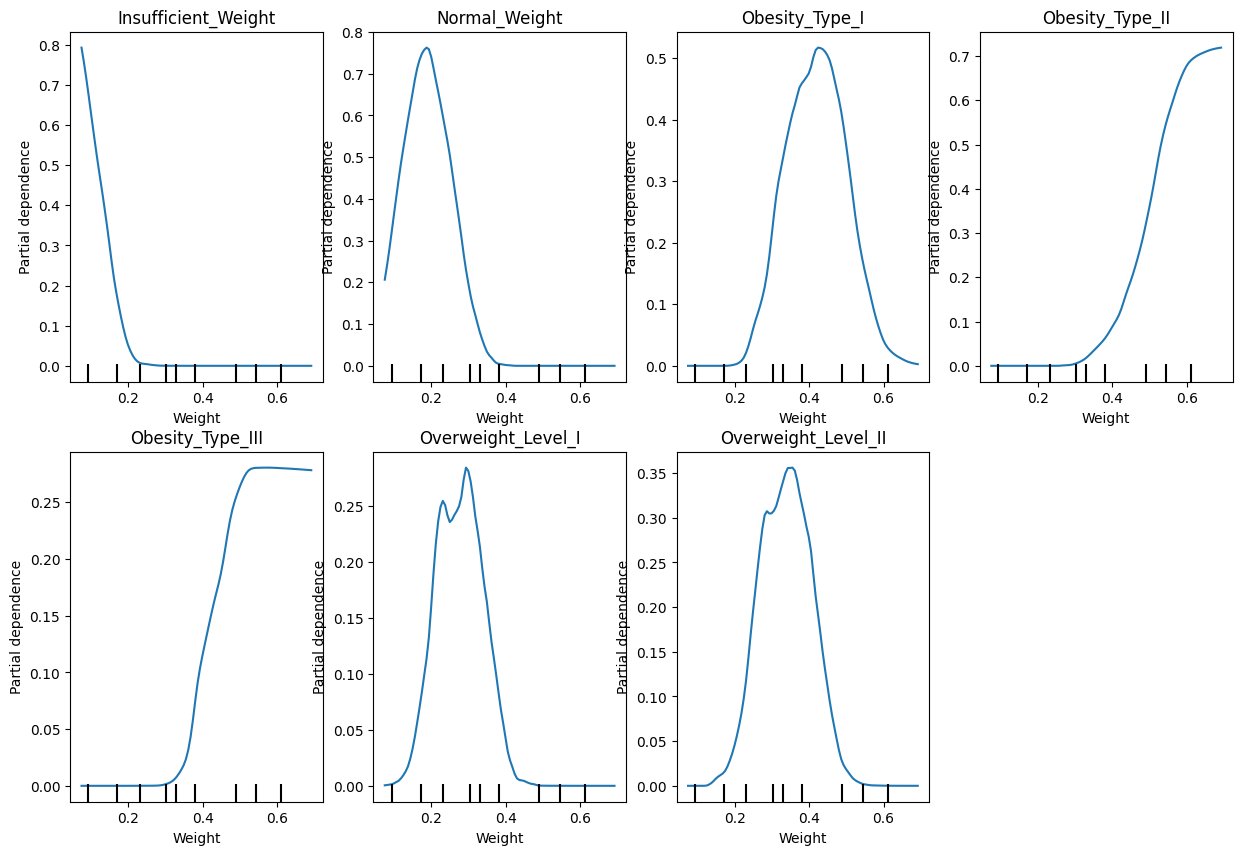

In [60]:
pdp = []
for i in range(7):
    pdp.append(PartialDependenceDisplay.from_estimator(estimator=nn_model, X=X_train, features=[3], target=i, feature_names=X.columns))

fig, ax = plt.subplots(2,4, figsize=(15, 10))
for i in range(7):
    pdp[i].plot(ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'{class_name[i]}')
    ax[i//4, i%4].set_xlabel('Weight')
    ax[i//4, i%4].set_ylabel('')
fig.delaxes(ax[1,3])